# Prony vs Fractional Models

Compare PyVisco Prony references to RheoJAX generalized and fractional fits.

In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports
Compare Prony-series reference curves against RheoJAX generalized and fractional fits using the time-domain dataset.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)
import arviz as az


INFO:2025-12-07 17:22:20,220:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load data and Prony terms

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyvisco' / 'time_master'
relax_df = pd.read_csv(DATA_DIR / 'time_user_master.csv')
relax_clean = relax_df.iloc[1:].astype(float)
t = relax_clean['t'].to_numpy()
E_t = relax_clean['E_relax'].to_numpy()

prony_path = DATA_DIR / 'prony_terms_KPf_MD.csv'
with open(prony_path) as fh:
    lines = [ln.strip() for ln in fh.readlines() if ln.strip()]
E0_line = next((ln for ln in lines if ln.startswith('# E0')), '# E0 = 1.0 MPa')
E0 = float(E0_line.split('=')[1].split()[0])  # MPa

prony_vals = [ln for ln in lines if not ln.startswith('#')]
prony_df = pd.DataFrame([list(map(float, row.split(','))) for row in prony_vals], columns=['rel_mod', 'rel_time'])

# Build reference relaxation curve from Prony series
prony_moduli = E0 * prony_df['rel_mod'].to_numpy()
prony_taus = prony_df['rel_time'].to_numpy()

E_prony = np.zeros_like(t)
for g, tau in zip(prony_moduli, prony_taus):
    E_prony += g * np.exp(-t / tau)

print(f"E0 = {E0:.2f} MPa, modes = {len(prony_moduli)}")
prony_df.head()


E0 = 1739.03 MPa, modes = 31


,rel_mod,rel_time
0,0.054565,0.01
1,0.019909,0.10
2,0.022591,1.00
3,0.011452,10.00
4,0.011624,100.00


## Fit RheoJAX models

In [4]:
gm = GeneralizedMaxwell(n_modes=6, modulus_type='tensile')
gm.fit(t, E_t, test_mode='relaxation', use_log_residuals=True)
gm_pred = gm.predict(t)
fm = FractionalMaxwellModel()
fm.fit(t, E_t, test_mode='relaxation', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='relaxation')

metrics = {
    'prony_ref_r2': r2_complex(E_t, E_prony),
    'gm_r2': gm.score(t, E_t),
    'fm_r2': r2_complex(E_t, fm_pred),
}
metrics


Auto-enabling multi-start optimization for very wide range (30.7 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.379829s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=13 | final_cost=4.790065e+07 | time=1.380s | final_gradient_norm=1566957452.1387854


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.312553s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=13 | final_cost=4.790065e+07 | time=0.313s | final_gradient_norm=1566957452.1387854


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.980643s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=4.726767e+07 | time=0.981s | final_gradient_norm=4301842872.211341


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.972641s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=4.726774e+07 | time=0.973s | final_gradient_norm=260843471.5355467


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.964107s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=4.727053e+07 | time=0.964s | final_gradient_norm=2379781497.1322446


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.897250s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=4.727792e+07 | time=0.897s | final_gradient_norm=50171392.943035275


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.638513s


Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=2 | final_cost=4.733564e+07 | time=0.639s | final_gradient_norm=0.08726020354349318


Element minimization: reducing from 6 to 1 modes


Auto-enabling multi-start optimization for very wide range (30.7 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 1.540288s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=6.616982e+05 | time=1.540s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


{'prony_ref_r2': 0.9812662052520316,
 'gm_r2': 0.4343575559174251,
 'fm_r2': -22784.252813352563}

## Overlay reference vs RheoJAX fits

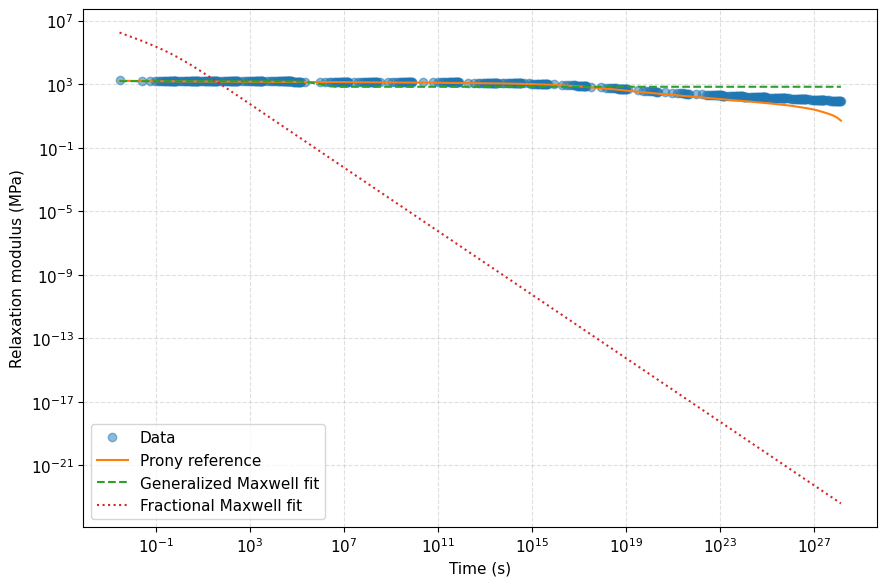

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(t, E_t, 'o', label='Data', alpha=0.5)
ax.loglog(t, E_prony, '-', label='Prony reference')
ax.loglog(t, gm_pred, '--', label='Generalized Maxwell fit')
ax.loglog(t, fm_pred, ':', label='Fractional Maxwell fit')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Relaxation modulus (MPa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Residual summary

In [6]:
def mpe(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

summary = pd.DataFrame([
    {'model': 'Prony reference', 'R2': metrics['prony_ref_r2'], 'MPE_%': mpe(E_t, E_prony)},
    {'model': 'Generalized Maxwell', 'R2': metrics['gm_r2'], 'MPE_%': mpe(E_t, gm_pred)},
    {'model': 'Fractional Maxwell', 'R2': metrics['fm_r2'], 'MPE_%': mpe(E_t, fm_pred)},
])
summary

,model,R2,MPE_%
0,Prony reference,0.981266,22.878967
1,Generalized Maxwell,0.434358,139.448414
2,Fractional Maxwell,-22784.252813,738.285177


## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Auto-enabling multi-start optimization for very wide range (30.7 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.414044s


Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=21 | final_cost=4.733564e+07 | time=0.414s | final_gradient_norm=9.961558550175043


Auto-enabling multi-start optimization for very wide range (30.7 decades, 5 starts)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 0.773662s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=6.616982e+05 | time=0.774s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


Model ranking (R²): [('gm', 0.434), ('fm', -22784.253)]


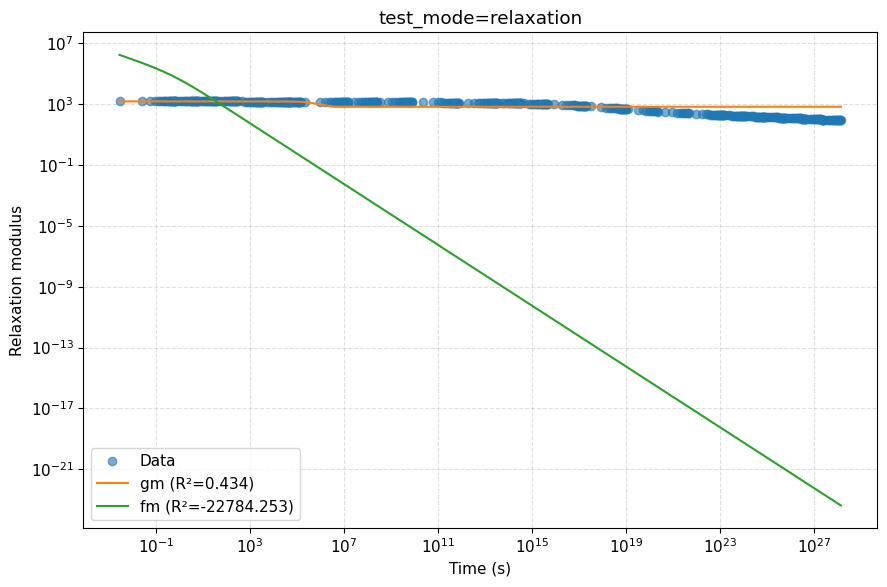

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<39:02,  1.71it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   7%|▋         | 282/4000 [00:00<00:06, 552.31it/s, 7 steps of size 1.03e+00. acc. prob=0.78]

warmup:  18%|█▊        | 709/4000 [00:00<00:02, 1365.29it/s, 3 steps of size 8.59e-01. acc. prob=0.79]

sample:  29%|██▊       | 1142/4000 [00:00<00:01, 2070.82it/s, 7 steps of size 6.31e-01. acc. prob=0.92]

sample:  39%|███▉      | 1579/4000 [00:00<00:00, 2652.96it/s, 7 steps of size 6.31e-01. acc. prob=0.92]

sample:  50%|█████     | 2001/4000 [00:01<00:00, 3068.84it/s, 3 steps of size 6.31e-01. acc. prob=0.92]

sample:  61%|██████    | 2433/4000 [00:01<00:00, 3412.60it/s, 3 steps of size 6.31e-01. acc. prob=0.91]

sample:  71%|███████▏  | 2856/4000 [00:01<00:00, 3641.36it/s, 7 steps of size 6.31e-01. acc. prob=0.91]

sample:  82%|████████▏ | 3292/4000 [00:01<00:00, 3846.58it/s, 7 steps of size 6.31e-01. acc. prob=0.91]

sample:  93%|█████████▎| 3733/4000 [00:01<00:00, 4009.65it/s, 7 steps of size 6.31e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2586.27it/s, 7 steps of size 6.31e-01. acc. prob=0.91]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   7%|▋         | 272/4000 [00:00<00:01, 2718.34it/s, 7 steps of size 8.46e-01. acc. prob=0.78]

warmup:  18%|█▊        | 702/4000 [00:00<00:00, 3645.95it/s, 7 steps of size 8.35e-01. acc. prob=0.79]

sample:  28%|██▊       | 1125/4000 [00:00<00:00, 3911.80it/s, 7 steps of size 5.22e-01. acc. prob=0.92]

sample:  38%|███▊      | 1534/4000 [00:00<00:00, 3981.17it/s, 7 steps of size 5.22e-01. acc. prob=0.93]

sample:  49%|████▉     | 1951/4000 [00:00<00:00, 4045.76it/s, 7 steps of size 5.22e-01. acc. prob=0.93]

sample:  59%|█████▉    | 2362/4000 [00:00<00:00, 4067.44it/s, 3 steps of size 5.22e-01. acc. prob=0.93]

sample:  69%|██████▉   | 2777/4000 [00:00<00:00, 4092.48it/s, 7 steps of size 5.22e-01. acc. prob=0.94]

sample:  80%|███████▉  | 3194/4000 [00:00<00:00, 4114.97it/s, 7 steps of size 5.22e-01. acc. prob=0.94]

sample:  90%|█████████ | 3608/4000 [00:00<00:00, 4121.42it/s, 15 steps of size 5.22e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4019.33it/s, 7 steps of size 5.22e-01. acc. prob=0.94] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   7%|▋         | 286/4000 [00:00<00:01, 2859.03it/s, 3 steps of size 5.49e-01. acc. prob=0.78]

warmup:  18%|█▊        | 705/4000 [00:00<00:00, 3637.67it/s, 7 steps of size 3.78e-01. acc. prob=0.79]

sample:  28%|██▊       | 1130/4000 [00:00<00:00, 3913.61it/s, 7 steps of size 5.77e-01. acc. prob=0.90]

sample:  39%|███▉      | 1555/4000 [00:00<00:00, 4045.92it/s, 7 steps of size 5.77e-01. acc. prob=0.91]

sample:  50%|████▉     | 1982/4000 [00:00<00:00, 4124.80it/s, 7 steps of size 5.77e-01. acc. prob=0.91]

sample:  60%|██████    | 2416/4000 [00:00<00:00, 4196.32it/s, 7 steps of size 5.77e-01. acc. prob=0.91]

sample:  71%|███████   | 2836/4000 [00:00<00:00, 4186.47it/s, 7 steps of size 5.77e-01. acc. prob=0.92]

sample:  81%|████████▏ | 3255/4000 [00:00<00:00, 4132.52it/s, 3 steps of size 5.77e-01. acc. prob=0.92]

sample:  92%|█████████▏| 3672/4000 [00:00<00:00, 4142.14it/s, 7 steps of size 5.77e-01. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4074.66it/s, 7 steps of size 5.77e-01. acc. prob=0.92]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   9%|▊         | 346/4000 [00:00<00:01, 3458.41it/s, 7 steps of size 7.11e-01. acc. prob=0.79]

warmup:  20%|█▉        | 790/4000 [00:00<00:00, 4033.50it/s, 3 steps of size 7.53e-01. acc. prob=0.79]

sample:  30%|███       | 1212/4000 [00:00<00:00, 4114.95it/s, 7 steps of size 5.37e-01. acc. prob=0.94]

sample:  41%|████      | 1628/4000 [00:00<00:00, 4130.71it/s, 7 steps of size 5.37e-01. acc. prob=0.93]

sample:  51%|█████     | 2042/4000 [00:00<00:00, 4117.50it/s, 7 steps of size 5.37e-01. acc. prob=0.93]

sample:  62%|██████▏   | 2465/4000 [00:00<00:00, 4151.95it/s, 7 steps of size 5.37e-01. acc. prob=0.93]

sample:  72%|███████▏  | 2895/4000 [00:00<00:00, 4196.06it/s, 7 steps of size 5.37e-01. acc. prob=0.93]

sample:  83%|████████▎ | 3315/4000 [00:00<00:00, 4191.09it/s, 3 steps of size 5.37e-01. acc. prob=0.93]

sample:  93%|█████████▎| 3735/4000 [00:00<00:00, 4191.41it/s, 7 steps of size 5.37e-01. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:00<00:00, 4141.43it/s, 7 steps of size 5.37e-01. acc. prob=0.93]

array([[<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_1'>, <Axes: xlabel='E_inf'>,
        <Axes: xlabel='sigma'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
        <Axes: title={'center': 'tau_1\n1'}>,
        <Axes: title={'center': 'tau_1\n2'}>,
        <Axes: title={'center': 'tau_1\n3'}>]], dtype=object)

array([<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

array([<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

In [7]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
